# ARIMA Model - Unemployment Rate (%)

Training (1997-2020), Training (2021-2023)

# Packages & Data Loading

## Packages

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import gdown
import requests
import warnings
from io import StringIO

import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Show graphs
%matplotlib inline

## Data Loading

In [3]:
# Google Drive file
file_id = '117pk3NKZPfYmHQyP452HeMV7_8Jq6_W0'

# Create the download URL
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Use requests to get file content
response = requests.get(download_url)
response.raise_for_status()  

# Load the CSV directly into df
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)

# Display data
print('Shape of the dataset:', df.shape)
print(df.dtypes)

Shape of the dataset: (349920, 14)
ref_date                   object
geo                        object
labour_force               object
industry                   object
sex                        object
age_group                  object
value_unemployment        float64
wages                      object
value_wage                float64
year                        int64
month                       int64
ref_date_numeric          float64
value_unemployment_log    float64
value_wage_log            float64
dtype: object


In [4]:
# Create a copy with selected columns
df_var = df[['ref_date', 'value_unemployment']].copy()

print(df_var.head())

     ref_date  value_unemployment
0  1997-01-01                 9.7
1  1997-01-01                 6.3
2  1997-01-01                 7.8
3  1997-01-01                 9.3
4  1997-01-01                 7.5


In [5]:
# Group df_var by 'ref_date' and calculate the median 'value_unemployment'
df_arima = df_var.groupby('ref_date').agg(
    median_unemployment=('value_unemployment', 'median')  # Calculate the median 
).reset_index()

print(df_arima)

       ref_date  median_unemployment
0    1997-01-01            12.916667
1    1997-02-01            10.700000
2    1997-03-01            10.766667
3    1997-04-01            11.925000
4    1997-05-01             9.975000
..          ...                  ...
319  2023-08-01             7.933333
320  2023-09-01             8.048674
321  2023-10-01             7.643939
322  2023-11-01             9.662319
323  2023-12-01             8.497222

[324 rows x 2 columns]


In [6]:
# Display shape and data types 
print('Shape of the dataset:\n', df_var.shape)
print(df_arima.dtypes)

# Convert 'ref_date' to datetime
df_arima['ref_date'] = pd.to_datetime(df_arima['ref_date'])

# Set 'ref_date' as the index 
df_arima = df_arima.set_index('ref_date')

# Verify the index is set and DatetimeIndex
print('\n\nIndex after setting ref_date:\n', df_arima.head().index)
print('\n\nData types after setting index:\n', df_arima.dtypes)
print('\n\nDataset:\n', df_arima.head(2))

Shape of the dataset:
 (349920, 2)
ref_date                object
median_unemployment    float64
dtype: object


Index after setting ref_date:
 DatetimeIndex(['1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01'],
              dtype='datetime64[ns]', name='ref_date', freq=None)


Data types after setting index:
 median_unemployment    float64
dtype: object


Dataset:
             median_unemployment
ref_date                       
1997-01-01            12.916667
1997-02-01            10.700000


# Visualization

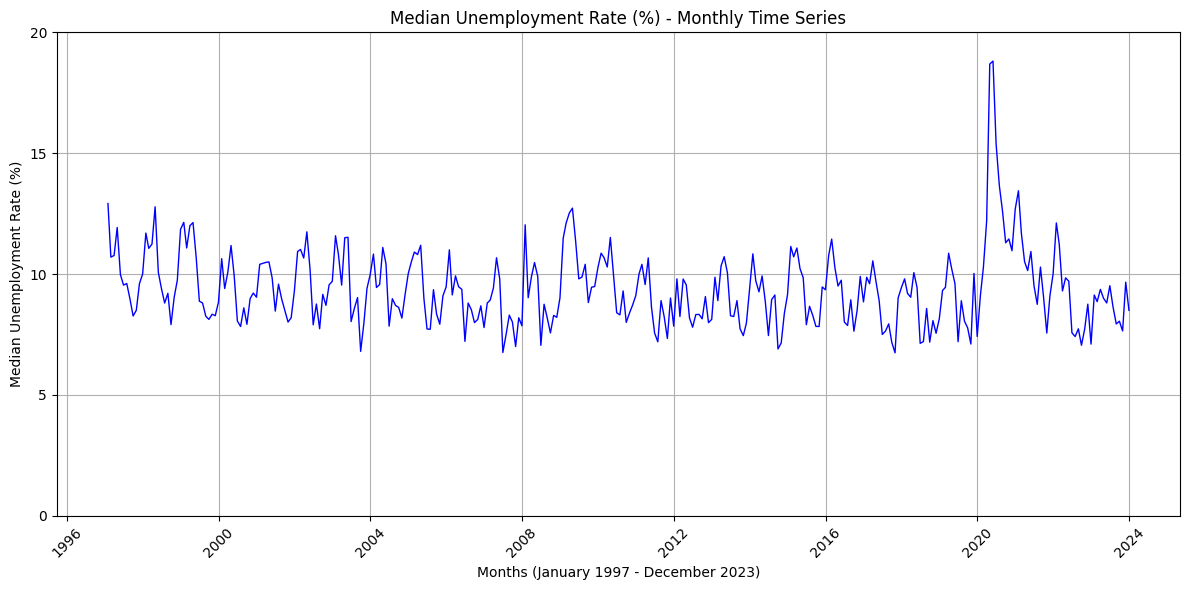

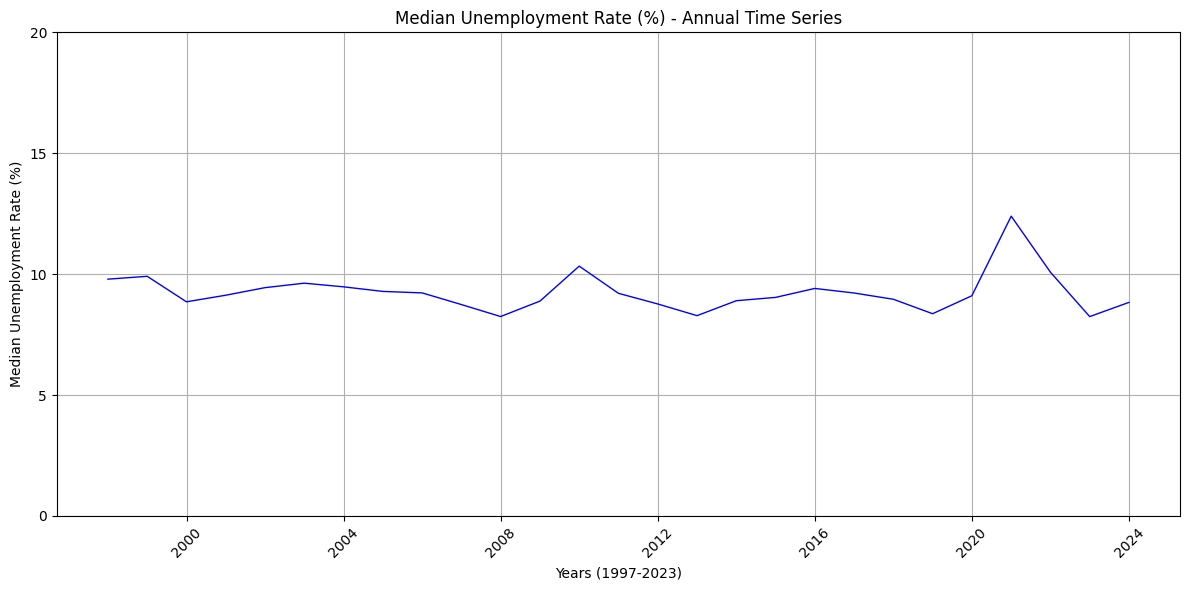

In [7]:
# Resampling to monthly 
df_monthly = df_arima.resample('ME').median()

# Resampling to yearly 
df_annual = df_arima.resample('YE').median()

# Set y-axis limits and tick intervals
y_min = 0
y_max = 20
y_ticks = range(y_min, y_max + 1, 5)

# Plot the monthly median unemployment rate
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly, color='blue', linewidth=1)
plt.title('Median Unemployment Rate (%) - Monthly Time Series')
plt.xlabel('Months (January 1997 - December 2023)')
plt.ylabel('Median Unemployment Rate (%)')
plt.xticks(rotation=45)
plt.yticks(y_ticks)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the yearly median unemployment rate
plt.figure(figsize=(12, 6))
plt.plot(df_annual.index, df_annual, color='blue', linewidth=1)
plt.title('Median Unemployment Rate (%) - Annual Time Series')
plt.xlabel('Years (1997-2023)')
plt.ylabel('Median Unemployment Rate (%)')
plt.xticks(rotation=45)
plt.ylim(y_min, y_max)
plt.yticks(y_ticks)
plt.grid(True)
plt.tight_layout()
plt.show()


# Stationarity

## ADF

Augmented Dickey-Fuller (ADF) Test

In [8]:
# Perform ADF test 
adf_test = adfuller(df_arima)
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary. Differencing may be required.")


ADF Test Results:
ADF Statistic: -4.238134371514253
p-value: 0.0005675214836028772
The data is stationary.


## ACF & PACF

Autocorrelation Function (ACF) & Partial Autocorrelation Function (PACF)

Data Summary:
       median_unemployment
count           324.000000
mean              9.393934
std               1.592885
min               6.739394
25%               8.242424
50%               9.156415
75%              10.233231
max              18.810000


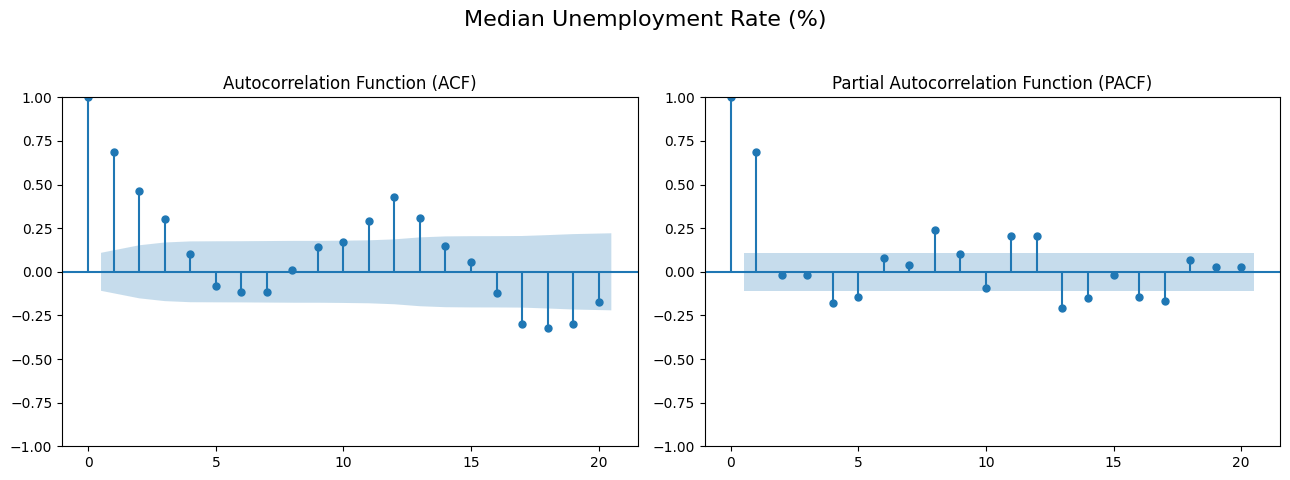

In [9]:
# Define function 
def acf_pacf_plotter(data, nlag=15, alpha=0.05, fig_size=(13, 5)):
        # Check and print descriptives
    print("Data Summary:")
    print(data.describe())

    # Create figure
    plt.figure(figsize=fig_size)
    layout = (1, 2)  

    # Assign axes 
    ax_acf = plt.subplot2grid(layout, (0, 0))  # Left side for ACF
    ax_pacf = plt.subplot2grid(layout, (0, 1))  # Right side for PACF

    # Plot ACF and PACF 
    plot_acf(data, alpha=alpha, lags=nlag, ax=ax_acf)
    plot_pacf(data, alpha=alpha, lags=nlag, ax=ax_pacf)

    # Set titles
    ax_acf.set_title('Autocorrelation Function (ACF)')
    ax_pacf.set_title('Partial Autocorrelation Function (PACF)')

    # Add figure title
    plt.suptitle('Median Unemployment Rate (%)', fontsize=16)

    # Adjust layout 
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show figure
    plt.show()

# Use Function with data
acf_pacf_plotter(df_arima, nlag=20)


## *Stationarity Conclusion*

The ADF test results indicate that the data is stationary. Although the ACF plot shows some notable spikes from lags 1 to 4, the correlations gradually decline thereafter with only a few other prominent lags. The PACF shows a strong spike at lag 1 followed by less prominent lags, indicating a possible AR(1) model. After considering these factors and the descriptive statistics (*M* = 9.39, *SD* = 1.59, range = 6.74-18.81), the variance was determined to not be instable enough to necessitate a log transformation. 

However, due to the noticeable trends presented with the Autocorrelation Function (ACF), further analysis will be conducted with a SARIMA model. 

# ARIMA Parameters

## Parameter Testing

In [10]:
warnings.filterwarnings("ignore")

data = df_arima

# Define p, d, q parameter ranges 
p = range(0, 3) # Autoregressive  
d = range(0, 2) # Differencing 
q = range(0, 3) # Moving average 

# Generate all different combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Initialize variables to store best AIC value and best parameter set
best_aic = float("inf")
best_pdq = None

# Grid Search: Iterate through combinations of p, d, q
for param in pdq:
    try:
        # Fit ARIMA model 
        model = ARIMA(data, order=param)
        model_fit = model.fit()
        
        # Evaluate using AIC 
        current_aic = model_fit.aic
        
        # Store lowest AIC
        if current_aic < best_aic:
            best_aic = current_aic
            best_pdq = param
            
        # Print iteration result 
        print(f"ARIMA{param} AIC: {current_aic:.2f}")

    except Exception as e:
        # Print error
        print(f"Error for ARIMA{param}: {e}")
        continue

# Print best model parameters and lowest AIC 
if best_pdq:
    print(f"\nBest ARIMA model: {best_pdq} with AIC: {best_aic:.2f}")
else:
    print("\nNo valid ARIMA model was found.")


ARIMA(0, 0, 0) AIC: 1224.15
ARIMA(0, 0, 1) AIC: 1077.83
ARIMA(0, 0, 2) AIC: 1042.67
ARIMA(0, 1, 0) AIC: 1057.17
ARIMA(0, 1, 1) AIC: 1052.75
ARIMA(0, 1, 2) AIC: 1049.89
ARIMA(1, 0, 0) AIC: 1013.08
ARIMA(1, 0, 1) AIC: 1014.80
ARIMA(1, 0, 2) AIC: 1016.80
ARIMA(1, 1, 0) AIC: 1054.17
ARIMA(1, 1, 1) AIC: 1014.35
ARIMA(1, 1, 2) AIC: 1016.13
ARIMA(2, 0, 0) AIC: 1014.80
ARIMA(2, 0, 1) AIC: 1014.75
ARIMA(2, 0, 2) AIC: 1016.46
ARIMA(2, 1, 0) AIC: 1051.14
ARIMA(2, 1, 1) AIC: 1052.96
ARIMA(2, 1, 2) AIC: 1014.50

Best ARIMA model: (1, 0, 0) with AIC: 1013.08


In [11]:
warnings.filterwarnings("ignore")

data = df_arima

# Define the p, d, q parameter ranges 
p = range(0, 3)  # Autoregressive 
d = range(0, 2)  # Differencing
q = range(0, 3)  # Moving average 

# Generate all different combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Initialize variables to store best BIC value and best parameter set
best_bic = float("inf")
best_pdq = None

# Grid Search: Iterate through combinations of p, d, q
for param in pdq:
    try:
        # Fit ARIMA model 
        model = ARIMA(data, order=param)
        model_fit = model.fit()

        # Evaluate using BIC
        current_bic = model_fit.bic

        # Store lowest BIC
        if current_bic < best_bic:
            best_bic = current_bic
            best_pdq = param

        # Print iteration result
        print(f"ARIMA{param} BIC: {current_bic:.2f}")

    except Exception as e:
        # Skip models that fail to converge or cause errors
        print(f"Error for ARIMA{param}: {e}")
        continue

# Print best model parameters and lowest BIC 
if best_pdq:
    print(f"\nBest ARIMA model: {best_pdq} with BIC: {best_bic:.2f}")
else:
    print("\nNo valid ARIMA model was found.")


ARIMA(0, 0, 0) BIC: 1231.71
ARIMA(0, 0, 1) BIC: 1089.17
ARIMA(0, 0, 2) BIC: 1057.79
ARIMA(0, 1, 0) BIC: 1060.95
ARIMA(0, 1, 1) BIC: 1060.31
ARIMA(0, 1, 2) BIC: 1061.23
ARIMA(1, 0, 0) BIC: 1024.42
ARIMA(1, 0, 1) BIC: 1029.93
ARIMA(1, 0, 2) BIC: 1035.70
ARIMA(1, 1, 0) BIC: 1061.73
ARIMA(1, 1, 1) BIC: 1025.68
ARIMA(1, 1, 2) BIC: 1031.24
ARIMA(2, 0, 0) BIC: 1029.92
ARIMA(2, 0, 1) BIC: 1033.66
ARIMA(2, 0, 2) BIC: 1039.14
ARIMA(2, 1, 0) BIC: 1062.47
ARIMA(2, 1, 1) BIC: 1068.07
ARIMA(2, 1, 2) BIC: 1033.39

Best ARIMA model: (1, 0, 0) with BIC: 1024.42


**Autoregressive** **(AR)**

ACF Plot - lag 1 is significant (> *p* = .05)

AIC/BIC = 1

*p* = 1


**Integrated** **(I)**

ADF Test - data is stationary

AIC/BIC = 0

*d* = 0


**Moving Average** **(MA)**

AIC/BIC = 0

*q* = 0

---

**Model Results**

ARIMA(1,0,0)

## Assign Training & Testing Sets

In [12]:
# Split into training and testing sets
train = df_arima['1997-01-01':'2020-12-01']
test = df_arima['2021-01-01':'2023-12-01']

print(train.head())
print(train.tail())

            median_unemployment
ref_date                       
1997-01-01            12.916667
1997-02-01            10.700000
1997-03-01            10.766667
1997-04-01            11.925000
1997-05-01             9.975000
            median_unemployment
ref_date                       
2020-08-01            12.592857
2020-09-01            11.293182
2020-10-01            11.452273
2020-11-01            10.964286
2020-12-01            12.687500


# ARIMA Model

## Fit Model

In [13]:
p = 1
d = 0
q = 0

# Fit ARIMA model 
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Model summary
print(model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     median_unemployment   No. Observations:                  288
Model:                  ARIMA(1, 0, 0)   Log Likelihood                -450.804
Date:                 Mon, 18 Nov 2024   AIC                            907.608
Time:                         23:07:08   BIC                            918.597
Sample:                     01-01-1997   HQIC                           912.011
                          - 12-01-2020                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4715      0.240     39.532      0.000       9.002       9.941
ar.L1          0.7031      0.037     18.767      0.000       0.630       0.777
sigma2         1.3369      0.068     19.547 

## Cross Validation

In [14]:
# Define procedure for TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Cross-validation metrics
cv_mse_scores = []
cv_rmse_scores = []
cv_mae_scores = []
cv_mape_scores = []

for train_index, val_index in tscv.split(train):
    # Split into train and validation sets
    train_cv, val_cv = train.iloc[train_index], train.iloc[val_index]

    # Fit the ARIMA model (assuming d=0 -> data is already stationary)
    model = ARIMA(train_cv, order=(1, 0, 0))
    model_fit = model.fit()

    # Forecast for the length of validation set
    forecast = model_fit.forecast(steps=len(val_cv))

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(val_cv, forecast)
    cv_mse_scores.append(mse)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    cv_rmse_scores.append(rmse)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(val_cv, forecast)
    cv_mae_scores.append(mae)

    # Calculate Mean Absolute Percentage Error (MAPE)
    epsilon = 1e-10

    # Convert to numpy arrays 
    val_cv_np = val_cv.values.flatten()
    forecast_np = np.array(forecast)

    # Filter out zero or near-zero values 
    valid_indices = val_cv_np > epsilon
    filtered_val_cv = val_cv_np[valid_indices]
    filtered_forecast = forecast_np[valid_indices]

    if len(filtered_val_cv) > 0:
        # MAPE calculation
        mape = np.mean(np.abs((filtered_val_cv - filtered_forecast) / (filtered_val_cv + epsilon))) * 100
    else:
        mape = np.nan  # If no valid values, set as NaN

    cv_mape_scores.append(mape)

# Cross-validation scores
print('Cross-Validation Mean Squared Error (MSE):', np.mean(cv_mse_scores))
print('Cross-Validation Root Mean Squared Error (RMSE):', np.mean(cv_rmse_scores))
print('Cross-Validation Mean Absolute Error (MAE):', np.mean(cv_mae_scores))
print('Cross-Validation Mean Absolute Percentage Error (MAPE):', np.nanmean(cv_mape_scores))  # Use np.nanmean to ignore NaNs


Cross-Validation Mean Squared Error (MSE): 2.8278541443118694
Cross-Validation Root Mean Squared Error (RMSE): 1.5932920315785126
Cross-Validation Mean Absolute Error (MAE): 1.251120853614237
Cross-Validation Mean Absolute Percentage Error (MAPE): 13.595790099671774


## Model Forecast

In [15]:
# ARIMA model
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Forecast using the final model
forecast = model_fit.forecast(steps=len(test))

# Print forecast 
print(forecast.head()) 

# Align the forecast index to the test index
forecast.index = test.index  

# Add forecast to the test data
test = test.copy()  
test['Predicted'] = forecast

2021-01-01    11.732618
2021-02-01    11.061258
2021-03-01    10.589235
2021-04-01    10.257364
2021-05-01    10.024032
Freq: MS, Name: predicted_mean, dtype: float64


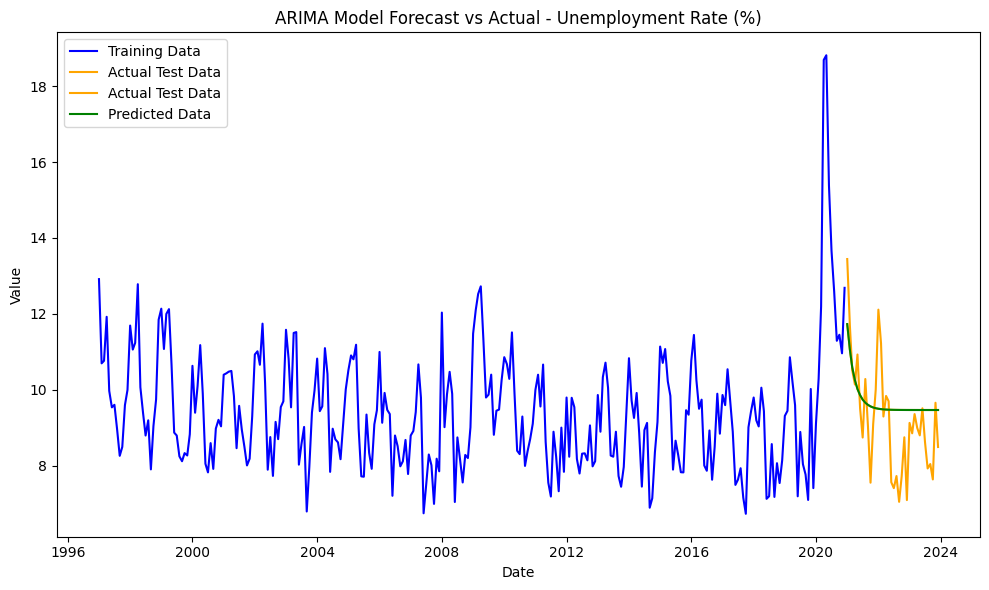

In [16]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data', color='blue', linewidth=1.5)
plt.plot(test.index, test, label='Actual Test Data', color='orange', linewidth=1.5)
plt.plot(test.index, test['Predicted'], label='Predicted Data', color='green', linewidth=1.5)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model Forecast vs Actual - Unemployment Rate (%)')
plt.legend()
plt.tight_layout()  
plt.show()


## Model Evaluation

Mean Squared Error (MSE): 1.585057093828868
Root Mean Squared Error (RMSE): 1.2589905058533475
Mean Absolute Error (MAE): 1.0012547464578991
Mean Absolute Percentage Error (MAPE): 11.674671515874142


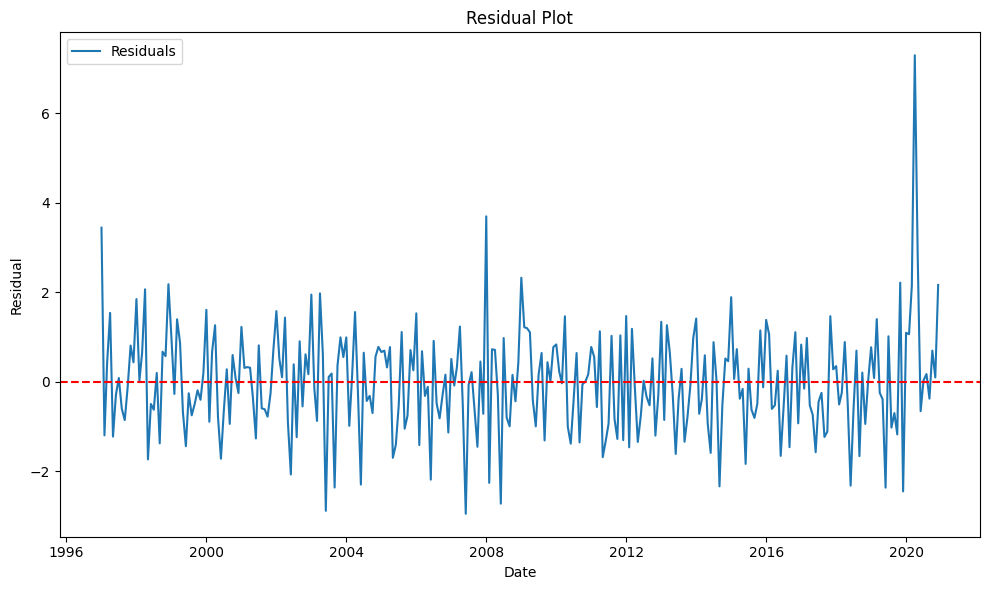

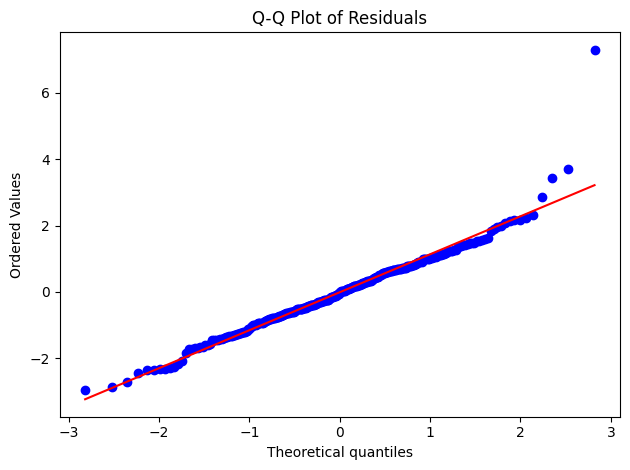

In [17]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['median_unemployment'], test['Predicted'])
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test['median_unemployment'], test['Predicted'])
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Absolute Percentage Error (MAPE)
epsilon = 1e-10 
filtered_test_data = test[test['median_unemployment'] > epsilon]  # Filter out values that are zero or near-zero
filtered_actual = filtered_test_data['median_unemployment']
filtered_predicted = filtered_test_data['Predicted']

if len(filtered_actual) > 0:
    mape = np.mean(np.abs((filtered_actual - filtered_predicted) / (filtered_actual + epsilon))) * 100
else:
    mape = np.nan

print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.legend()
plt.tight_layout()
plt.show()

# Q-Q plot for normality check
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
